In [1]:
import pandas as pd
import numpy as np
import re

# Load NRC VAD
vad = pd.read_csv(
    "NRC-VAD-Lexicon.txt",
    sep="\t",
    names=["word","valence","arousal","dominance"],
    skiprows=1
)

vad_dict = vad.set_index("word")[["valence","arousal"]].to_dict("index")


In [9]:
import pandas as pd

# 1. Load your Ekman-labelled file
df = pd.read_csv("reddit_with_ekman_emotions.csv")  # change name if needed

print(df.columns)


Index(['id', 'created_utc', 'subreddit', 'listing', 'title', 'selftext', 'url',
       'num_comments', 'comments', 'raw_text', 'clean_text', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'predicted_ekman_emotion',
       'emotion_confidence'],
      dtype='object')


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2790/207510338.py:4: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("reddit_with_ekman_emotions.csv")  # change name if needed


In [10]:
# Find the Ekman label column
ekman_col = next((c for c in df.columns if "ekman" in c.lower()), None)
if ekman_col is None:
    raise ValueError("No Ekman label column found (e.g., 'predicted_ekman_emotion').")

# Pick a text column in priority order
text_candidates = ["clean_text", "proc_text", "selftext", "raw_text", "text", "title"]
text_col = next((c for c in text_candidates if c in df.columns), None)

if text_col is None:
    raise ValueError(
        "No suitable text column found. "
        "Add one of these: 'clean_text', 'proc_text', 'selftext', 'raw_text', 'text', 'title'."
    )

print("Using Ekman column:", ekman_col)
print("Using text column:", text_col)


Using Ekman column: predicted_ekman_emotion
Using text column: clean_text


In [11]:
# 2. Load NRC VAD lexicon
vad = pd.read_csv(
    "NRC-VAD-Lexicon.txt",
    sep="\t",
    names=["word", "valence", "arousal", "dominance"],
    skiprows=1
)

# Build a dict: word -> {"valence": v, "arousal": a}
vad_dict = vad.set_index("word")[["valence", "arousal"]].to_dict("index")

len(vad_dict)


19970

In [12]:
import re
import numpy as np

# Basic tokenizer: lowercase + split on non-letters
token_pattern = re.compile(r"[a-z]+")

def compute_vad(text):
    if not isinstance(text, str):
        return np.nan, np.nan
    
    words = token_pattern.findall(text.lower())
    vals, aros = [], []
    
    for w in words:
        if w in vad_dict:
            vals.append(vad_dict[w]["valence"])
            aros.append(vad_dict[w]["arousal"])
    
    if vals and aros:
        return float(np.mean(vals)), float(np.mean(aros))
    else:
        return np.nan, np.nan


In [13]:
# 3. Apply NRC VAD to all posts
df[["valence", "arousal"]] = df[text_col].apply(
    lambda t: pd.Series(compute_vad(t))
)

df[["valence", "arousal"]].describe()


,valence,arousal
count,42962.000000,42962.000000
mean,0.579042,0.465965
std,0.076032,0.056070
min,0.000000,0.112000
25%,0.543037,0.436833
50%,0.583333,0.461506
75%,0.620170,0.490224
max,1.000000,0.941000


In [15]:
df_vad = df.dropna(subset=["valence", "arousal"]).copy()
len(df), len(df_vad)



(43733, 42962)

In [16]:
# 5. Aggregate by Ekman emotion
ekman_summary = (
    df_vad
    .groupby(ekman_col)[["valence", "arousal"]]
    .mean()
    .reset_index()
)

ekman_summary


,predicted_ekman_emotion,valence,arousal
0,anger,0.549964,0.485815
1,disgust,0.543755,0.484796
2,fear,0.549472,0.486269
3,joy,0.619482,0.457041
4,neutral,0.573570,0.454721
5,sadness,0.573088,0.463004
6,surprise,0.582068,0.463816


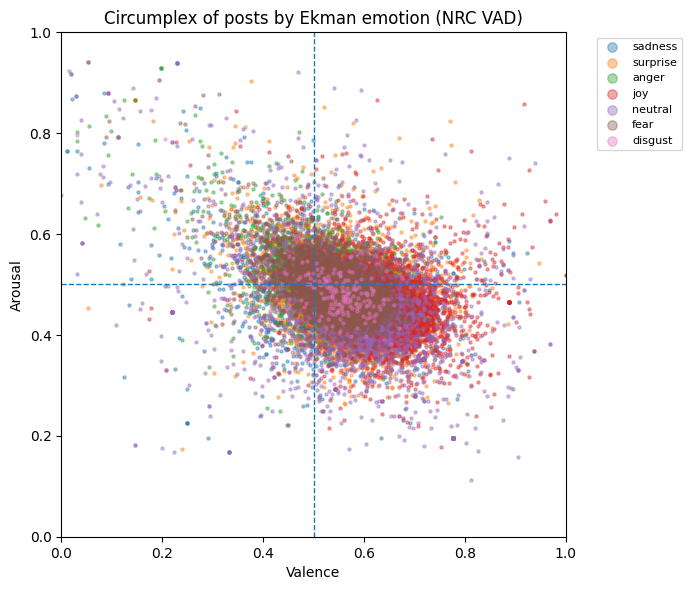

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

# Get a small color palette
ekman_labels = df_vad[ekman_col].unique()
colors = plt.cm.tab10(range(len(ekman_labels)))  # up to 10 emotions cleanly

color_map = dict(zip(ekman_labels, colors))

for emo in ekman_labels:
    subset = df_vad[df_vad[ekman_col] == emo]
    plt.scatter(
        subset["valence"],
        subset["arousal"],
        s=5,
        alpha=0.4,
        label=emo,
        c=[color_map[emo]]
    )

plt.axvline(0.5, linestyle="--", linewidth=1)
plt.axhline(0.5, linestyle="--", linewidth=1)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.title("Circumplex of posts by Ekman emotion (NRC VAD)")
plt.legend(markerscale=3, fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# Load NRC-VAD
vad = pd.read_csv(
    "NRC-VAD-Lexicon.txt",
    sep="\t",
    names=["word", "valence", "arousal", "dominance"],
    skiprows=1
)

vad_dict = vad.set_index("word")[["valence", "arousal"]].to_dict("index")


In [20]:
import re

def clean_tokens(text):
    if pd.isna(text):
        return []
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    return [w for w in text.split() if w.strip()]


In [21]:
def compute_vad(text):
    tokens = clean_tokens(text)
    vals, aros = [], []

    for w in tokens:
        if w in vad_dict:
            vals.append(vad_dict[w]["valence"])
            aros.append(vad_dict[w]["arousal"])

    if len(vals) == 0:
        return 0.0, 0.0   # neutral fallback

    return sum(vals)/len(vals), sum(aros)/len(aros)


In [22]:
df["valence"], df["arousal"] = zip(*df["clean_text"].apply(compute_vad))


In [23]:
ekman_palette = {
    "anger": "#d73027",
    "disgust": "#1a9641",
    "fear": "#4575b4",
    "joy": "#fdae61",
    "neutral": "#aaaaaa",
    "sadness": "#313695",
    "surprise": "#fee090"
}


In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_circumplex(df_sub, title, filename):

    plt.figure(figsize=(8, 10))

    # Draw circumplex circle
    theta = np.linspace(0, 2*np.pi, 400)
    x = np.cos(theta)
    y = np.sin(theta)
    plt.plot(x, y, color="grey", linewidth=2)

    # Zero lines
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(0, color="black", linewidth=1)

    # Quadrant labels
    plt.text(0, 1.05, "Activated", ha="center", fontsize=12)
    plt.text(0, -1.10, "Deactivated", ha="center", fontsize=12)
    plt.text(-1.15, 0, "Unpleasant", va="center", fontsize=12, rotation=90)
    plt.text(1.15, 0, "Pleasant", va="center", fontsize=12, rotation=90)

    # ---- Scatter ----
    for emo, subdf in df_sub.groupby("predicted_ekman_emotion"):
        plt.scatter(
            subdf["valence"],
            subdf["arousal"],
            s=8,
            alpha=0.20,
            color=ekman_palette.get(emo, "black"),
            label=emo,
        )

    # ---- Compute centroids ----
    centroids = df_sub.groupby("predicted_ekman_emotion")[["valence", "arousal"]].mean()

    for emo, row in centroids.iterrows():
        plt.scatter(row["valence"], row["arousal"], s=80, color="black")
        plt.text(row["valence"]+0.02, row["arousal"]+0.02, emo,
                 fontsize=10, fontweight="bold")

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel("Valence (Unpleasant → Pleasant)")
    plt.ylabel("Arousal (Deactivation → Activation)")
    plt.title(title, fontsize=14)
    plt.legend(title="Ekman Emotions", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [27]:
import pandas as pd

reddit = pd.read_csv("reddit_with_ekman_emotions.csv")
bb = pd.read_csv("bb_with_ekman_emotions.csv")


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2790/653078109.py:3: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit = pd.read_csv("reddit_with_ekman_emotions.csv")


In [28]:
reddit["platform"] = "Reddit"
bb["platform"] = "BeyondBlue"


In [29]:
common_cols = list(set(reddit.columns).intersection(set(bb.columns)))
print("Common columns:", common_cols)


Common columns: ['predicted_ekman_emotion', 'clean_text', 'comments', 'platform', 'emotion_confidence', 'raw_text', 'num_comments']


In [30]:
combined = pd.concat([reddit[common_cols], bb[common_cols]], ignore_index=True)


In [31]:
combined.to_csv("combined_dataset.csv", index=False)


In [32]:
import pandas as pd

# Load NRC-VAD
vad = pd.read_csv(
    "NRC-VAD-Lexicon.txt",
    sep="\t",
    names=["word", "valence", "arousal", "dominance"],
    skiprows=1
)

vad_dict = vad.set_index("word")[["valence", "arousal"]].to_dict("index")


In [33]:
import pandas as pd
df = pd.read_csv("combined_dataset.csv")
df.head()


,predicted_ekman_emotion,clean_text,comments,platform,emotion_confidence,raw_text,num_comments
0,sadness,i get really depressed after drinking too much...,NaN,Reddit,0.833457,I get really depressed after drinking too much...,0
1,sadness,am i smart i have chronic depression and dpdr ...,NaN,Reddit,0.504654,Am i smart? I have chronic depression and DPDR...,0
2,surprise,is this just laziness i know that stuff like b...,NaN,Reddit,0.817124,Is this just laziness? I know that stuff like ...,0
3,anger,i m just so stressed and tired of existing fir...,NaN,Reddit,0.582970,I’m just so stressed and tired of existing. Fi...,0
4,sadness,i think i might be depressed but i feel like m...,NaN,Reddit,0.690031,"I think I might be depressed, but I feel like ...",0


In [34]:
df.columns


Index(['predicted_ekman_emotion', 'clean_text', 'comments', 'platform',
       'emotion_confidence', 'raw_text', 'num_comments'],
      dtype='object')

In [35]:
vad = pd.read_csv(
    "NRC-VAD-Lexicon.txt",
    sep="\t",
    names=["word", "valence", "arousal", "dominance"],
    skiprows=1
)

vad_dict = vad.set_index("word")[["valence", "arousal"]].to_dict("index")


In [36]:
import re

def clean_tokens(text):
    if pd.isna(text):
        return []
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return [w for w in text.split() if w.strip() != ""]


In [41]:
def compute_vad(text):
    tokens = clean_tokens(text)
    vals, aros = [], []

    for w in tokens:
        if w in vad_dict:
            vals.append(vad_dict[w]["valence"])
            aros.append(vad_dict[w]["arousal"])

    if len(vals) == 0:
        return None, None

    return sum(vals) / len(vals), sum(arros) / len(arros)


In [43]:
def compute_vad(text):
    tokens = clean_tokens(text)
    vals, aros = [], []  # <-- correct variable name

    for w in tokens:
        if w in vad_dict:
            vals.append(vad_dict[w]["valence"])
            aros.append(vad_dict[w]["arousal"])

    if len(vals) == 0:
        return None, None

    return sum(vals) / len(vals), sum(aros) / len(aros)


In [44]:
df["valence"], df["arousal"] = zip(*df["clean_text"].apply(compute_vad))


In [45]:
def clean_tokens(text):
    if pd.isna(text):
        return []
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return [w for w in text.split() if w.strip() != ""]


In [46]:
df["valence"] = df["valence"].fillna(0)
df["arousal"] = df["arousal"].fillna(0)


In [47]:
emotion_order = ["sadness", "fear", "anger", "disgust", "joy", "surprise", "neutral"]

palette = {
    "sadness":  "#5e3c99",
    "fear":     "#1b7837",
    "anger":    "#d73027",
    "disgust":  "#66a61e",
    "joy":      "#fee08b",
    "surprise": "#74add1",
    "neutral":  "#bdbdbd"
}


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def draw_circumplex(ax):
    theta = np.linspace(0, 2*np.pi, 400)
    ax.plot(np.cos(theta), np.sin(theta), color="gray", linewidth=1.5)

    # Axis lines
    ax.axhline(0, color="gray", linewidth=1)
    ax.axvline(0, color="gray", linewidth=1)

    # Labels
    ax.text(1.05, 0, "Pleasant", va="center")
    ax.text(-1.1, 0, "Unpleasant", va="center")
    ax.text(0, 1.1, "Activated", ha="center")
    ax.text(0, -1.1, "Deactivated", ha="center")

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel("Valence (Unpleasant → Pleasant)")
    ax.set_ylabel("Arousal (Deactivation → Activation)")
    ax.set_aspect("equal")


In [49]:
centroids = df.groupby("predicted_ekman_emotion")[["valence","arousal"]].mean()
centroids


,valence,arousal
predicted_ekman_emotion,,
anger,0.551055,0.483117
disgust,0.544341,0.484505
fear,0.555889,0.483111
joy,0.623327,0.451366
neutral,0.470715,0.371758
sadness,0.579868,0.460530
surprise,0.584689,0.461973


In [52]:
import numpy as np

centroids = (
    df_vad.groupby(ekman_col)[["valence", "arousal"]]
    .mean()
    .reset_index()
)
centroids


,predicted_ekman_emotion,valence,arousal
0,anger,0.549964,0.485815
1,disgust,0.543755,0.484796
2,fear,0.549472,0.486269
3,joy,0.619482,0.457041
4,neutral,0.573570,0.454721
5,sadness,0.573088,0.463004
6,surprise,0.582068,0.463816


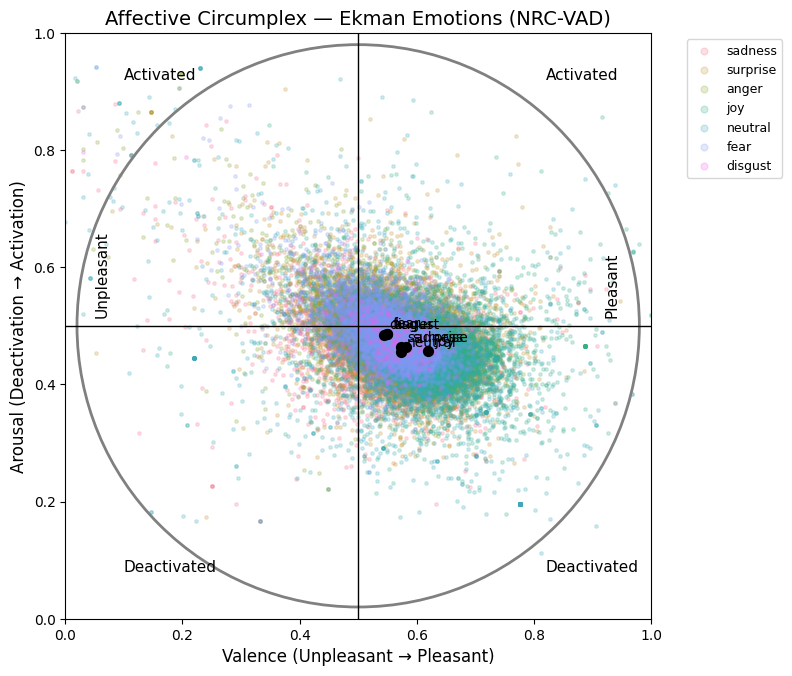

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))

# consistent color palette
ekman_labels = df_vad[ekman_col].unique()
palette = sns.color_palette("husl", len(ekman_labels))
color_map = dict(zip(ekman_labels, palette))

# -----------------------------
# 1) Scatter points (faded)
# -----------------------------
for emo in ekman_labels:
    subset = df_vad[df_vad[ekman_col] == emo]
    plt.scatter(
        subset["valence"],
        subset["arousal"],
        s=6,
        alpha=0.22,
        label=emo,
        color=color_map[emo]
    )

# -----------------------------
# 2) Draw circumplex circle
# -----------------------------
circle = plt.Circle((0.5, 0.5), 0.48, edgecolor="grey", linewidth=2, fill=False)
plt.gca().add_patch(circle)

# -----------------------------
# 3) Axis lines
# -----------------------------
plt.axvline(0.5, color="black", linewidth=1)
plt.axhline(0.5, color="black", linewidth=1)

# -----------------------------
# 4) Add quadrant labels
# -----------------------------
plt.text(0.1, 0.92, "Activated", fontsize=11)
plt.text(0.82, 0.92, "Activated", fontsize=11)
plt.text(0.1, 0.08, "Deactivated", fontsize=11)
plt.text(0.82, 0.08, "Deactivated", fontsize=11)

plt.text(0.05, 0.52, "Unpleasant", fontsize=11, rotation=90)
plt.text(0.92, 0.52, "Pleasant", fontsize=11, rotation=90)

# -----------------------------
# 5) Emotion centroids
# -----------------------------
for _, row in centroids.iterrows():
    vx, ax = row["valence"], row["arousal"]
    emo = row[ekman_col]
    plt.scatter(vx, ax, c="black", s=50)
    plt.text(vx+0.01, ax+0.01, emo, fontsize=10)

# -----------------------------
# Formatting
# -----------------------------
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Valence (Unpleasant → Pleasant)", fontsize=12)
plt.ylabel("Arousal (Deactivation → Activation)", fontsize=12)

plt.title("Affective Circumplex — Ekman Emotions (NRC-VAD)", fontsize=14)
plt.legend(markerscale=2, fontsize=9, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()


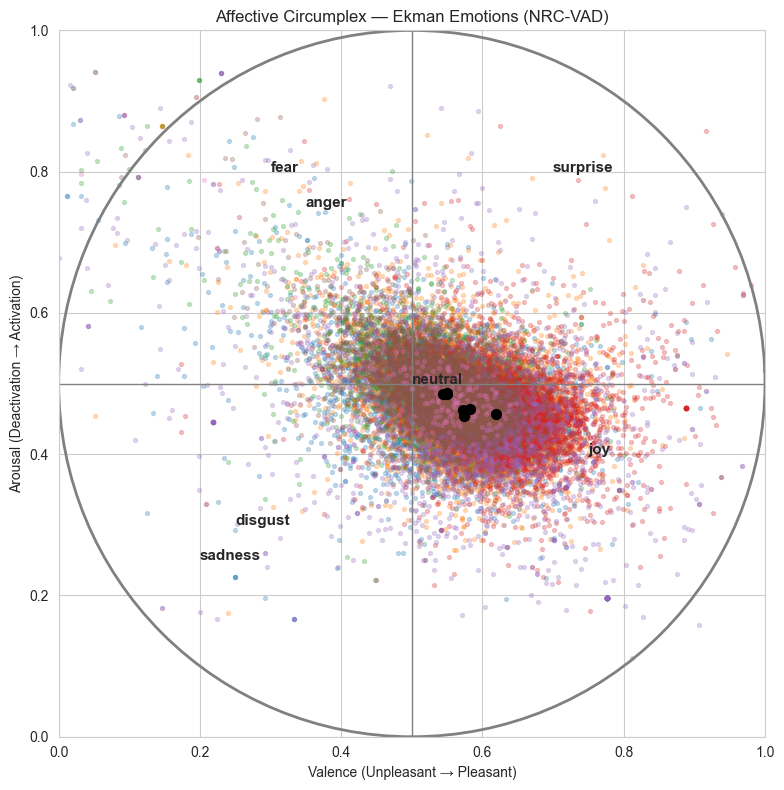

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = df_vad.copy()  # your circumplex dataframe

ekman_col = "predicted_ekman_emotion"

# --------------------------
# 1. Compute centroids
# --------------------------
centroids = (
    df.groupby(ekman_col)[["valence", "arousal"]]
    .mean()
    .reset_index()
)

# --------------------------
# 2. Define quadrant label positions
# --------------------------
label_positions = {
    "sadness": (0.20, 0.25),    # low valence, low arousal
    "disgust": (0.25, 0.30),    # low valence, low-mid arousal
    "fear":    (0.30, 0.80),    # low valence, high arousal
    "anger":   (0.35, 0.75),    # low-mid val, high arousal
    "surprise":(0.70, 0.80),    # high valence, high arousal
    "joy":     (0.75, 0.40),    # high valence, low arousal
    "neutral": (0.50, 0.50),    # centre
}

# --------------------------
# 3. Plot circumplex
# --------------------------
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")

# scatter points
for emo in df[ekman_col].unique():
    subset = df[df[ekman_col] == emo]
    plt.scatter(
        subset["valence"], subset["arousal"],
        s=8, alpha=0.25, label=emo
    )

# --------------------------
# 4. Draw circle & axes
# --------------------------
circle = plt.Circle((0.5, 0.5), 0.5, color="gray", fill=False, linewidth=2)
plt.gca().add_artist(circle)

plt.axvline(0.5, color="gray", linewidth=1)
plt.axhline(0.5, color="gray", linewidth=1)

# --------------------------
# 5. Plot centroid points (TRUE)
# --------------------------
plt.scatter(
    centroids["valence"],
    centroids["arousal"],
    c="black",
    s=50,
    label="Centroids"
)

# --------------------------
# 6. Plot centroid *labels* moved to quadrant anchors
# --------------------------
for _, row in centroids.iterrows():
    emo = row[ekman_col]
    lx, ly = label_positions.get(emo, (row["valence"], row["arousal"]))  
    plt.text(
        lx, ly, emo,
        fontsize=11, weight="bold"
    )

plt.title("Affective Circumplex — Ekman Emotions (NRC-VAD)")
plt.xlabel("Valence (Unpleasant → Pleasant)")
plt.ylabel("Arousal (Deactivation → Activation)")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
plt.show()


In [57]:
df_vad["platform"] = df_vad["subreddit"].apply(
    lambda x: "BeyondBlue" if "beyondblue" in str(x).lower() else "Reddit"
)


In [60]:
df_reddit = pd.read_csv("reddit_with_ekman_emotions.csv")
df_bb     = pd.read_csv("bb_with_ekman_emotions.csv")

df_reddit["platform"] = "Reddit"
df_bb["platform"] = "BeyondBlue"

df = pd.concat([df_reddit, df_bb], ignore_index=True)
df.to_csv("combined_dataset.csv", index=False)


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2790/4173421316.py:1: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reddit = pd.read_csv("reddit_with_ekman_emotions.csv")


In [67]:
import pandas as pd

bb = pd.read_csv("bb_with_ekman_emotions.csv")   # ← change if needed

# Inspect columns
bb.head()
bb.columns


Index(['keyword', 'page', 'post_preview', 'thread_url', 'post_date',
       'num_comments', 'comments', 'raw_text', 'clean_text',
       'predicted_ekman_emotion', 'emotion_confidence'],
      dtype='object')

In [68]:
ekman_col = next(c for c in bb.columns if "ekman" in c.lower())
print("Using Ekman column:", ekman_col)


Using Ekman column: predicted_ekman_emotion


In [69]:
vad = pd.read_csv(
    "NRC-VAD-Lexicon.txt",
    sep="\t",
    names=["word","valence","arousal","dominance"],
    skiprows=1
)

vad_dict = vad.set_index("word")[["valence","arousal"]].to_dict("index")


In [70]:
import re
import numpy as np

def clean_tokens(text):
    if pd.isna(text):
        return []
    return re.findall(r"[a-zA-Z']+", text.lower())

def compute_vad(text):
    vals, aros = [], []
    for w in clean_tokens(text):
        if w in vad_dict:
            vals.append(vad_dict[w]["valence"])
            aros.append(vad_dict[w]["arousal"])
    if len(vals)==0:
        return np.nan, np.nan
    return np.mean(vals), np.mean(aros)

bb["valence"], bb["arousal"] = zip(*bb["clean_text"].apply(compute_vad))


In [71]:
bb_vad = bb.dropna(subset=["valence","arousal"]).copy()


In [77]:
import pandas as pd

reddit = pd.read_csv("reddit_with_ekman_emotions.csv")
bb = pd.read_csv("bb_with_ekman_emotions.csv")

reddit["platform"] = "reddit"
bb["platform"] = "beyondblue"

df = pd.concat([reddit, bb], ignore_index=True)

/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2790/548733551.py:3: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit = pd.read_csv("reddit_with_ekman_emotions.csv")


In [78]:
import pandas as pd

# Load NRC VAD v2.1
vad = pd.read_csv(
    "NRC-VAD-Lexicon-v2.1.txt",
    sep="\t",
    comment=";",          # ignore any comment lines if present
    encoding="utf-8"
)

# Normalise column names to lowercase without spaces
vad.columns = [c.strip().lower() for c in vad.columns]
print(vad.columns)


Index(['term', 'valence', 'arousal', 'dominance'], dtype='object')


In [79]:
# Find the relevant columns by name pattern
word_col = next(c for c in vad.columns if "word" in c or "term" in c)
val_col  = next(c for c in vad.columns if "valence" in c)
aro_col  = next(c for c in vad.columns if "arousal" in c)

# Keep only what we need
vad_small = vad[[word_col, val_col, aro_col]].copy()
vad_small.rename(columns={
    word_col: "word",
    val_col: "valence",
    aro_col: "arousal"
}, inplace=True)

# Build lookup dict: {"word": {"valence": v, "arousal": a}, ...}
vad_dict = vad_small.set_index("word")[["valence", "arousal"]].to_dict("index")


In [80]:
def compute_vad(text):
    words = str(text).lower().split()
    vals, aros = [], []
    for w in words:
        if w in vad_dict:
            vals.append(vad_dict[w]["valence"])
            aros.append(vad_dict[w]["arousal"])
    if vals and aros:
        return sum(vals)/len(vals), sum(aros)/len(aros)
    return None, None

# Choose the appropriate text column
text_col = None
for c in ["clean_text", "proc_text", "raw_text", "selftext", "title"]:
    if c in df.columns:
        text_col = c
        break

print("Using text column:", text_col)

df["valence"], df["arousal"] = zip(*df[text_col].apply(compute_vad))
df = df.dropna(subset=["valence", "arousal"])


Using text column: clean_text


In [81]:
df[["valence","arousal"]].describe()


,valence,arousal
count,55064.000000,55064.000000
mean,0.105379,-0.040457
std,0.086250,0.066140
min,-0.979000,-1.000000
25%,0.068050,-0.067539
50%,0.111680,-0.045657
75%,0.147344,-0.018821
max,0.938000,1.000000


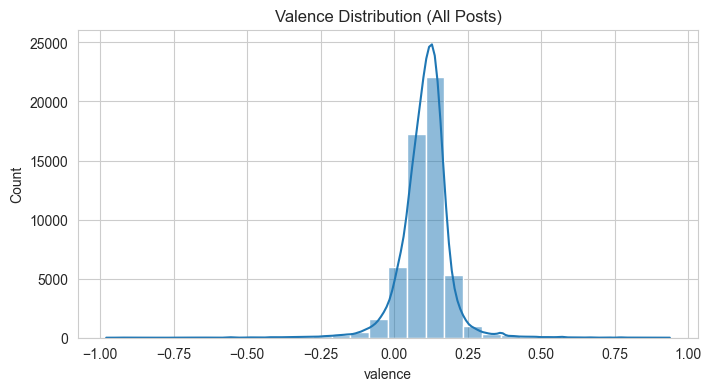

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df["valence"], bins=30, kde=True)
plt.title("Valence Distribution (All Posts)")
plt.show()


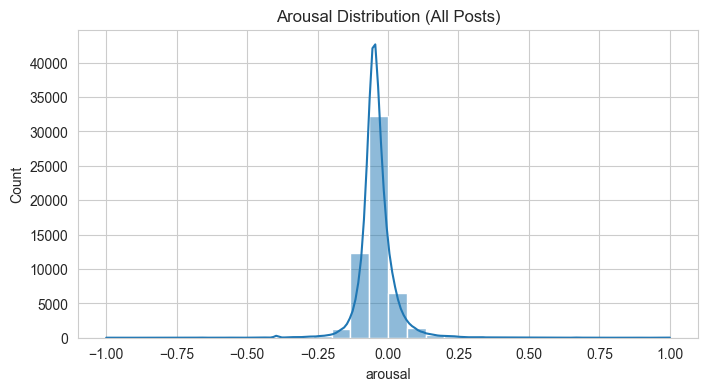

In [83]:
plt.figure(figsize=(8,4))
sns.histplot(df["arousal"], bins=30, kde=True)
plt.title("Arousal Distribution (All Posts)")
plt.show()


In [84]:
reddit_df = df[df["platform"] == "reddit"]
bb_df = df[df["platform"] == "beyondblue"]


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2790/2089284227.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="platform", y="valence", palette="Set2")
/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2790/2089284227.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="platform", y="arousal", palette="Set2")


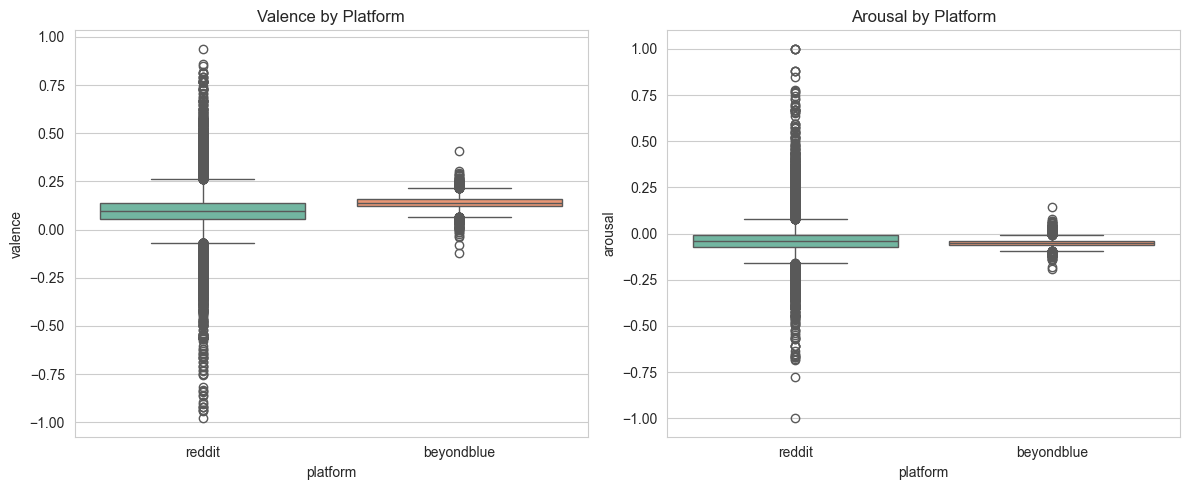

In [89]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(data=df, x="platform", y="valence", palette="Set2")
plt.title("Valence by Platform")

plt.subplot(1,2,2)
sns.boxplot(data=df, x="platform", y="arousal", palette="Set2")
plt.title("Arousal by Platform")

plt.tight_layout()
plt.show()


In [90]:
def quadrant(row):
    if row["valence"] >= 0.5 and row["arousal"] >= 0.5:
        return "Q1: High Valence, High Arousal"
    elif row["valence"] < 0.5 and row["arousal"] >= 0.5:
        return "Q2: Low Valence, High Arousal"
    elif row["valence"] < 0.5 and row["arousal"] < 0.5:
        return "Q3: Low Valence, Low Arousal"
    else:
        return "Q4: High Valence, Low Arousal"

df["quadrant"] = df.apply(quadrant, axis=1)


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If not already loaded
# df = pd.read_csv("your_file_with_vad_and_ekman.csv")

ekman_col = "predicted_ekman_emotion"   # change if your column name is different

# Drop rows with missing values
df_plot = df.dropna(subset=["valence", "arousal", ekman_col]).copy()

# Rescale from [0,1] → [-1,1]
df_plot["valence_z"] = 2 * (df_plot["valence"] - 0.5)
df_plot["arousal_z"] = 2 * (df_plot["arousal"] - 0.5)


In [95]:
centroids = (
    df_plot.groupby(ekman_col)[["valence_z", "arousal_z"]]
    .mean()
    .reset_index()
)


In [97]:
reddit_df = df_plot[df_plot["platform"] == "reddit"].copy()
bb_df     = df_plot[df_plot["platform"] == "beyondblue"].copy()


In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_circumplex(data, title, ekman_col="predicted_ekman_emotion"):
    plt.figure(figsize=(9,9))

    # ---------- Scatter ----------
    sns.scatterplot(
        data=data,
        x="valence_z",
        y="arousal_z",
        hue=ekman_col,
        alpha=0.25,
        s=10,
        palette="tab10",
        linewidth=0
    )

    # ---------- Ellipse boundary ----------
    theta = np.linspace(0, 2*np.pi, 400)
    a, b = 1.0, 1.0
    x_ell = a * np.cos(theta)
    y_ell = b * np.sin(theta)
    plt.plot(x_ell, y_ell, color="grey", linewidth=2)

    # ---------- Quadrant lines ----------
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(0, color="black", linewidth=1)

    # ---------- Quadrant labels ----------
    plt.text(0.55, 0.65, "Q1\nHigh Valence\nHigh Arousal", fontsize=10, ha="center")
    plt.text(-0.55, 0.65, "Q2\nLow Valence\nHigh Arousal", fontsize=10, ha="center")
    plt.text(-0.55, -0.65, "Q3\nLow Valence\nLow Arousal", fontsize=10, ha="center")
    plt.text(0.55, -0.65, "Q4\nHigh Valence\nLow Arousal", fontsize=10, ha="center")

    # ---------- Centroids ----------
    centroids = (
        data.groupby(ekman_col)[["valence_z", "arousal_z"]]
        .mean().reset_index()
    )

    plt.scatter(
        centroids["valence_z"],
        centroids["arousal_z"],
        facecolors="none",
        edgecolors="black",
        s=100,
        linewidths=2,
        zorder=5
    )

    # Label centroids slightly offset
    for _, row in centroids.iterrows():
        plt.text(
            row["valence_z"] + 0.03,
            row["arousal_z"] + 0.03,
            row[ekman_col],
            fontsize=9,
            color="black"
        )

    # ---------- Labels & formatting ----------
    plt.title(title, fontsize=14)
    plt.xlabel("Valence (Unpleasant → Pleasant)")
    plt.ylabel("Arousal (Deactivation → Activation)")
    plt.xlim(-1.05, 1.05)
    plt.ylim(-1.05, 1.05)
    plt.gca().set_aspect("equal", 'box')
    plt.legend(title=ekman_col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [105]:
import pandas as pd

reddit = pd.read_csv("reddit_with_ekman_emotions.csv")
bb     = pd.read_csv("bb_with_ekman_emotions.csv")

# Add platform labels
reddit["platform"] = "reddit"
bb["platform"]     = "beyondblue"

# Combine
df = pd.concat([reddit, bb], ignore_index=True)


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2790/1911926247.py:3: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit = pd.read_csv("reddit_with_ekman_emotions.csv")


In [106]:
# Load NRC VAD v2.1
vad = pd.read_csv(
    "NRC-VAD-Lexicon-v2.1.txt",
    sep="\t",
    comment=";",
    encoding="utf-8"
)

# Normalise column names
vad.columns = [c.strip().lower() for c in vad.columns]

# Automatically detect correct columns
word_col = next(c for c in vad.columns if "word" in c or "term" in c)
val_col  = next(c for c in vad.columns if "valence" in c)
aro_col  = next(c for c in vad.columns if "arousal" in c)

vad_small = vad[[word_col, val_col, aro_col]].rename(
    columns={word_col: "word", val_col: "valence", aro_col: "arousal"}
)

# Build dictionary
vad_dict = vad_small.set_index("word")[["valence", "arousal"]].to_dict("index")


In [107]:
text_col = None
for c in ["clean_text", "proc_text", "raw_text", "selftext", "title"]:
    if c in df.columns:
        text_col = c
        break

print("Using text column:", text_col)


Using text column: clean_text


In [108]:
def compute_vad(text):
    words = str(text).lower().split()
    vals, aros = [], []
    for w in words:
        if w in vad_dict:
            vals.append(vad_dict[w]["valence"])
            aros.append(vad_dict[w]["arousal"])
    if vals:
        return sum(vals)/len(vals), sum(aros)/len(aros)
    return None, None

df["valence"], df["arousal"] = zip(*df[text_col].apply(compute_vad))

# Drop posts where VAD not found
df = df.dropna(subset=["valence", "arousal"])


In [ ]:
# Z-score standardisation
df["valence_z"] = (df["valence"] - df["valence"].mean()) / df["valence"].std()
df["arousal_z"] = (df["arousal"] - df["arousal"].mean()) / df["arousal"].std()

df["valence_z"] = df["valence_z"].clip(-0.9, 0.9)
df["arousal_z"] = df["arousal_z"].clip(-1.0, 1.0)



In [110]:
reddit_df = df[df["platform"] == "reddit"].copy()
bb_df     = df[df["platform"] == "beyondblue"].copy()


In [114]:
df["valence_z"] = df["valence_z"].clip(-0.9, 0.9)
df["arousal_z"] = df["arousal_z"].clip(-1.0, 1.0)


In [115]:
sns.kdeplot(
    data=data,
    x="valence_z",
    y="arousal_z",
    fill=True,
    cmap="Greys",
    alpha=0.5,
    bw_adjust=1.8,   # 👈 critical fix, smoother shape
    thresh=0.1
)


NameError: name 'data' is not defined

In [116]:
import pandas as pd

reddit = pd.read_csv("reddit_with_ekman_emotions.csv")
bb     = pd.read_csv("bb_with_ekman_emotions.csv")

reddit["platform"] = "reddit"
bb["platform"] = "beyondblue"

df = pd.concat([reddit, bb], ignore_index=True)


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2790/3321961970.py:3: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit = pd.read_csv("reddit_with_ekman_emotions.csv")


In [117]:
vad = pd.read_csv(
    "NRC-VAD-Lexicon-v2.1.txt",
    sep="\t",
    comment=";",
    encoding="utf-8"
)

# Normalise names
vad.columns = [c.strip().lower() for c in vad.columns]

word_col = next(c for c in vad.columns if "word" in c or "term" in c)
val_col  = next(c for c in vad.columns if "valence" in c)
aro_col  = next(c for c in vad.columns if "arousal" in c)

vad_small = vad[[word_col, val_col, aro_col]].rename(
    columns={word_col: "word", val_col: "valence", aro_col: "arousal"}
)

vad_dict = vad_small.set_index("word")[["valence", "arousal"]].to_dict("index")


In [118]:
text_col = None
for c in ["clean_text", "proc_text", "raw_text", "selftext", "title"]:
    if c in df.columns:
        text_col = c
        break

print("Using text column:", text_col)


Using text column: clean_text


In [119]:
def compute_vad(text):
    words = str(text).lower().split()
    vals, aros = [], []
    for w in words:
        if w in vad_dict:
            vals.append(vad_dict[w]["valence"])
            aros.append(vad_dict[w]["arousal"])
    if vals:
        return sum(vals)/len(vals), sum(aros)/len(aros)
    return None, None

df["valence"], df["arousal"] = zip(*df[text_col].apply(compute_vad))
df = df.dropna(subset=["valence", "arousal"])


In [120]:
# Center around median
df["valence_c"] = df["valence"] - df["valence"].median()
df["arousal_c"] = df["arousal"] - df["arousal"].median()

# Scale to -1 … 1 using max absolute value
df["valence_c"] = df["valence_c"] / df["valence_c"].abs().max()
df["arousal_c"] = df["arousal_c"] / df["arousal_c"].abs().max()


In [121]:
reddit_df = df[df["platform"] == "reddit"].copy()
bb_df     = df[df["platform"] == "beyondblue"].copy()


In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_circumplex_final(data, title, ekman_col="predicted_ekman_emotion"):

    plt.figure(figsize=(9,9))

    # KDE background
    sns.kdeplot(
        data=data,
        x="valence_c",
        y="arousal_c",
        fill=True,
        cmap="Greys",
        alpha=0.55,
        bw_adjust=1.5,
        thresh=0.08
    )

    # Scatter sample (cleaner)
    sample = data.sample(min(4000, len(data)), random_state=42)

    sns.scatterplot(
        data=sample,
        x="valence_c",
        y="arousal_c",
        hue=ekman_col,
        palette="tab10",
        s=16,
        alpha=0.35,
        linewidth=0
    )

    # Circumplex ellipse
    theta = np.linspace(0, 2*np.pi, 400)
    a, b = 1.0, 1.25
    plt.plot(a*np.cos(theta), b*np.sin(theta), color="grey", linewidth=2)

    # Quadrants
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(0, color="black", linewidth=1)

    plt.text(0.55, 0.75, "Q1\nHigh Valence\nHigh Arousal", ha="center")
    plt.text(-0.55, 0.75, "Q2\nLow Valence\nHigh Arousal", ha="center")
    plt.text(-0.55, -0.75, "Q3\nLow Valence\nLow Arousal", ha="center")
    plt.text(0.55, -0.75, "Q4\nHigh Valence\nLow Arousal", ha="center")

    # Emotion centroids
    centroids = (
        data.groupby(ekman_col)[["valence_c", "arousal_c"]]
        .mean().reset_index()
    )

    plt.scatter(
        centroids["valence_c"],
        centroids["arousal_c"],
        facecolors="none",
        edgecolors="black",
        s=130,
        linewidths=2,
        zorder=5
    )

    for _, row in centroids.iterrows():
        plt.text(
            row["valence_c"] + 0.035,
            row["arousal_c"] + 0.035,
            row[ekman_col],
            fontsize=9
        )

    plt.title(title, fontsize=14)
    plt.xlabel("Valence (Unpleasant → Pleasant)")
    plt.ylabel("Arousal (Deactivation → Activation)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.35, 1.35)
    plt.gca().set_aspect("equal", 'box')
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


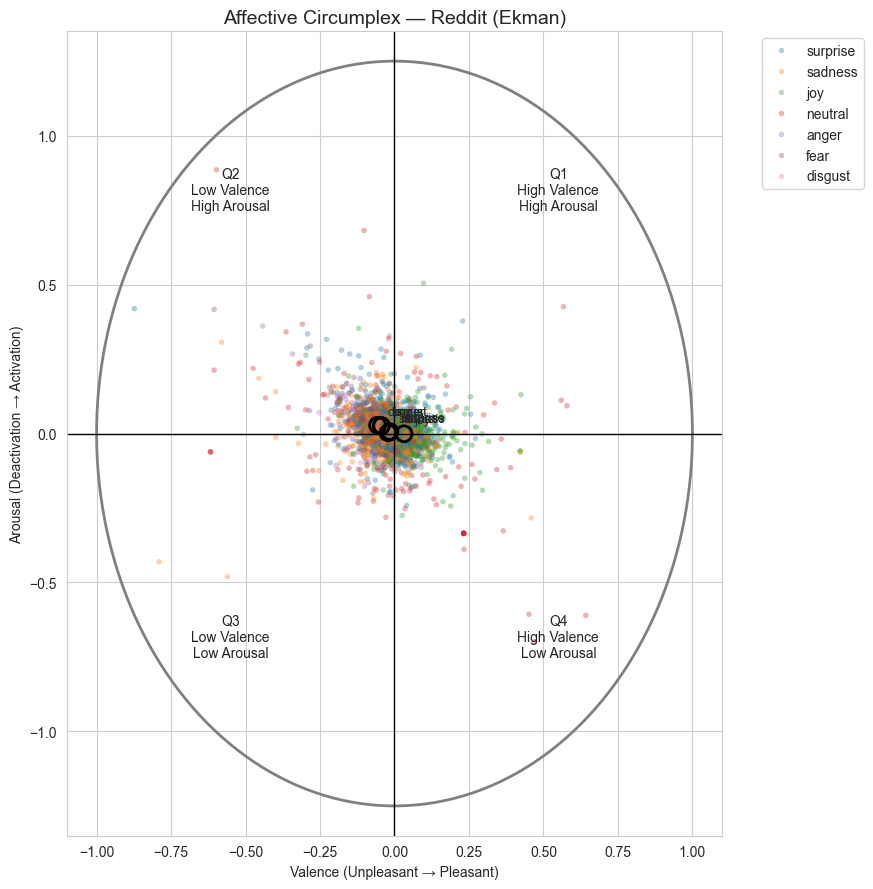

In [123]:
plot_circumplex_final(reddit_df, "Affective Circumplex — Reddit (Ekman)")


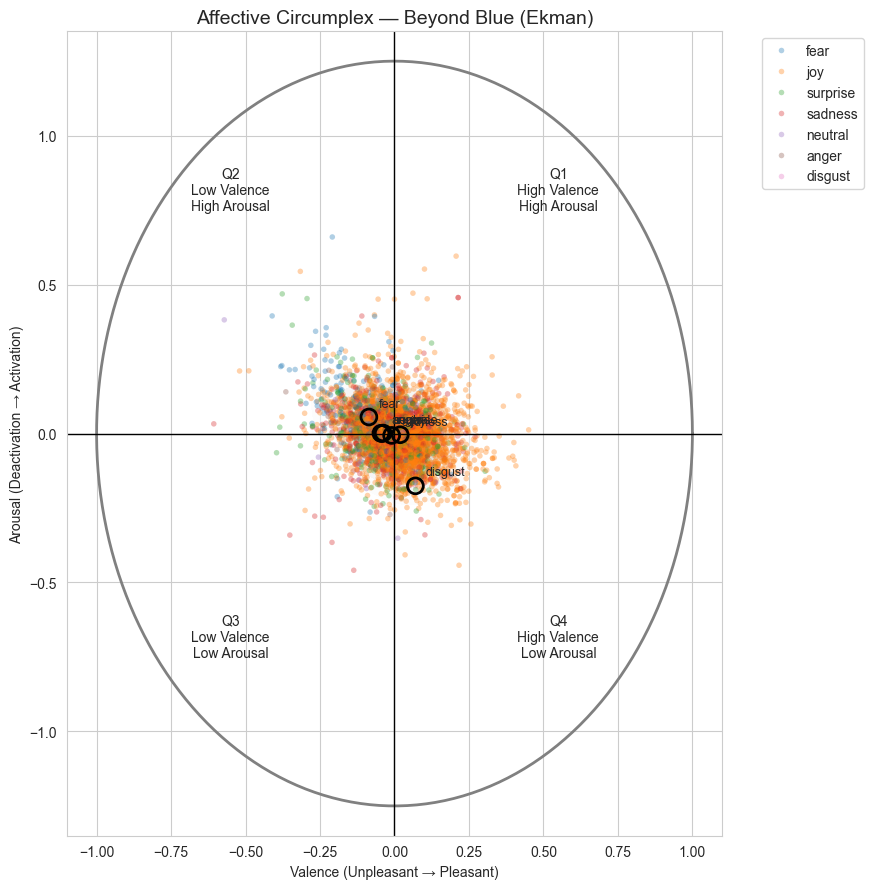

In [128]:
plot_circumplex_final(bb_df, "Affective Circumplex — Beyond Blue (Ekman)")


In [125]:
def compute_vad_strict(text):
    words = str(text).lower().split()
    vals, aros = [], []
    for w in words:
        if w in vad_dict:
            val = vad_dict[w]["valence"]
            aro = vad_dict[w]["arousal"]

            # only include words with strong affect
            if (abs(val - 0.5) > 0.1) or (abs(aro - 0.5) > 0.1):
                vals.append(val)
                aros.append(aro)

    if vals:
        return sum(vals)/len(vals), sum(aros)/len(aros)

    return None, None

df["valence"], df["arousal"] = zip(*df[text_col].apply(compute_vad_strict))
df = df.dropna(subset=["valence","arousal"])


In [127]:
bb_df["valence_c"]  = bb_df["valence"]  - bb_df["valence"].mean()
bb_df["arousal_c"]  = bb_df["arousal"]  - bb_df["arousal"].mean()

reddit_df["valence_c"]  = reddit_df["valence"]  - reddit_df["valence"].mean()
reddit_df["arousal_c"]  = reddit_df["arousal"]  - reddit_df["arousal"].mean()

# Normalise each platform independently
bb_df["valence_c"]  /= bb_df["valence_c"].abs().max()
bb_df["arousal_c"]  /= bb_df["arousal_c"].abs().max()

reddit_df["valence_c"]  /= reddit_df["valence_c"].abs().max()
reddit_df["arousal_c"]  /= reddit_df["arousal_c"].abs().max()


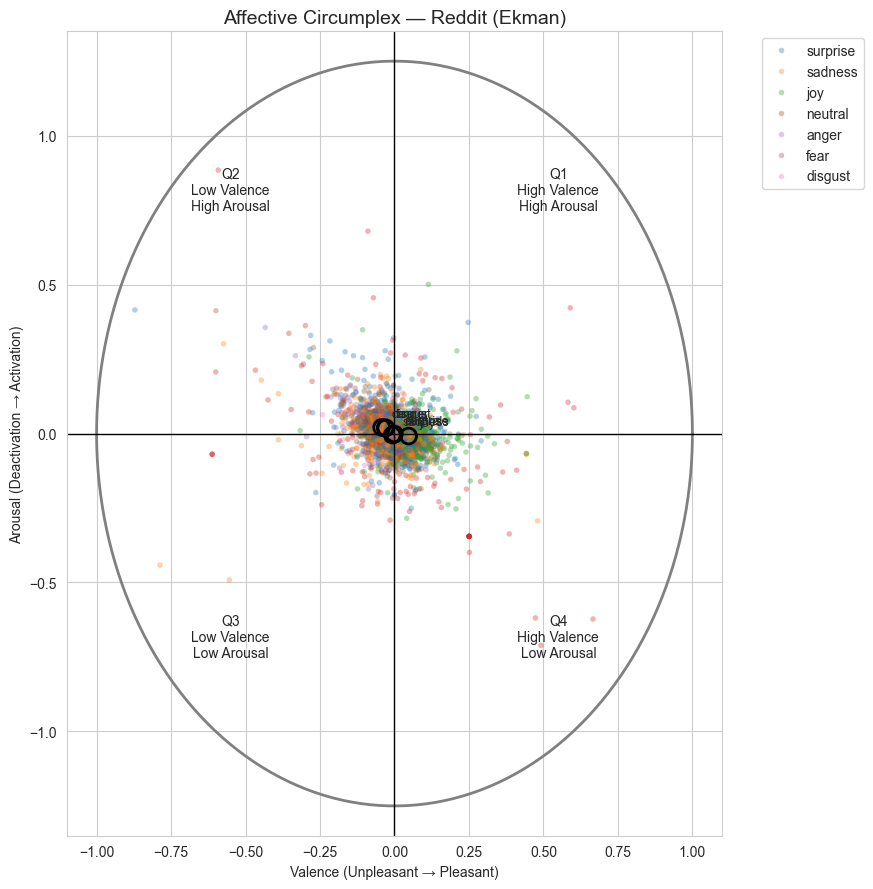

In [129]:
plot_circumplex_final(reddit_df, "Affective Circumplex — Reddit (Ekman)")

In [130]:
def get_quadrant(row):
    if row["valence_c"] >= 0 and row["arousal_c"] >= 0:
        return "Q1: High Valence, High Arousal"
    elif row["valence_c"] < 0 and row["arousal_c"] >= 0:
        return "Q2: Low Valence, High Arousal"
    elif row["valence_c"] < 0 and row["arousal_c"] < 0:
        return "Q3: Low Valence, Low Arousal"
    else:
        return "Q4: High Valence, Low Arousal"

df["quadrant"] = df.apply(get_quadrant, axis=1)


In [131]:
quad_counts = (
    df.groupby(["platform", "quadrant"])
    .size()
    .reset_index(name="count")
)

quad_counts["percentage"] = quad_counts.groupby("platform")["count"].apply(lambda x: 100 * x / x.sum())

quad_counts


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2790/2642945440.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  quad_counts["percentage"] = quad_counts.groupby("platform")["count"].apply(lambda x: 100 * x / x.sum())


,platform,quadrant,count,percentage
0,beyondblue,"Q1: High Valence, High Arousal",3331,27.758333
1,beyondblue,"Q2: Low Valence, High Arousal",1152,9.600000
2,beyondblue,"Q3: Low Valence, Low Arousal",795,6.625000
3,beyondblue,"Q4: High Valence, Low Arousal",6722,56.016667
4,reddit,"Q1: High Valence, High Arousal",7350,17.067620
5,reddit,"Q2: Low Valence, High Arousal",15699,36.455044
6,reddit,"Q3: Low Valence, Low Arousal",9886,22.956530
7,reddit,"Q4: High Valence, Low Arousal",10129,23.520806


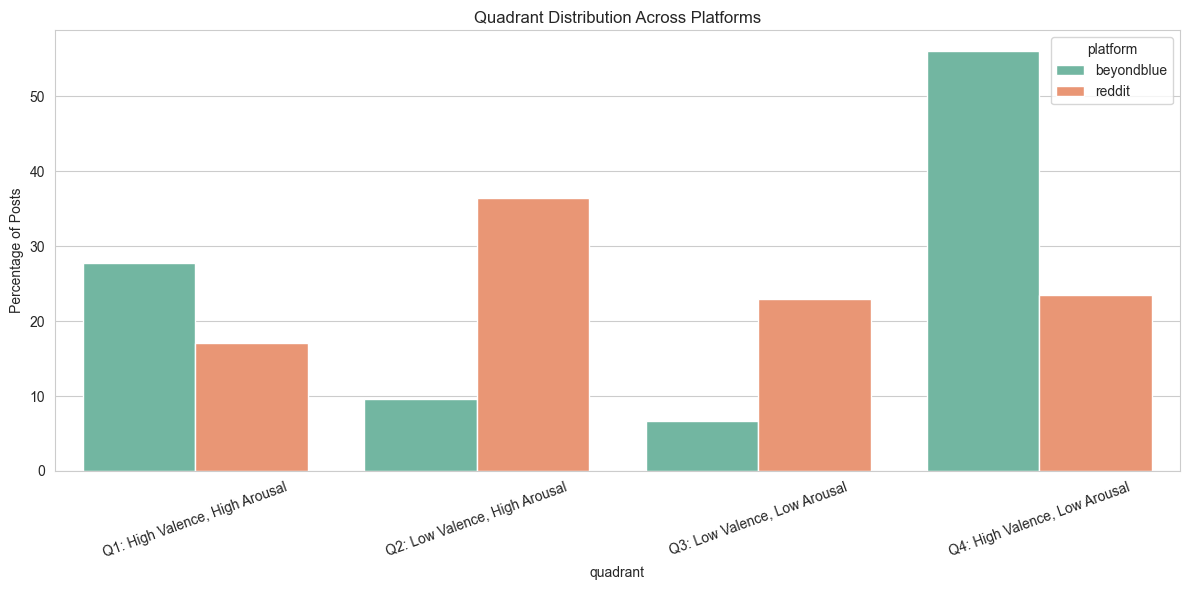

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    data=quad_counts,
    x="quadrant",
    y="percentage",
    hue="platform",
    palette="Set2"
)

plt.title("Quadrant Distribution Across Platforms")
plt.ylabel("Percentage of Posts")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [133]:
val_ar_summary = (
    df.groupby("platform")[["valence_c", "arousal_c"]]
    .agg(["mean", "std"])
)

val_ar_summary


valence_c           arousal_c          
                mean       std      mean       std
platform                                          
beyondblue  0.025688  0.028256 -0.004368  0.018611
reddit     -0.014545  0.086145  0.007577  0.070626

In [134]:
emotion_stats = (
    df.groupby(["platform", "predicted_ekman_emotion"])[["valence_c", "arousal_c"]]
    .mean()
    .reset_index()
    .sort_values(["platform", "predicted_ekman_emotion"])
)

emotion_stats


,platform,predicted_ekman_emotion,valence_c,arousal_c
0,beyondblue,anger,0.014462,-0.004211
1,beyondblue,disgust,0.042947,-0.036979
2,beyondblue,fear,0.004540,0.005943
3,beyondblue,joy,0.030423,-0.005119
4,beyondblue,neutral,0.015306,-0.004363
5,beyondblue,sadness,0.023329,-0.005540
6,beyondblue,surprise,0.016344,-0.004088
7,reddit,anger,-0.043222,0.026316
8,reddit,disgust,-0.056881,0.027889
9,reddit,fear,-0.044982,0.026249


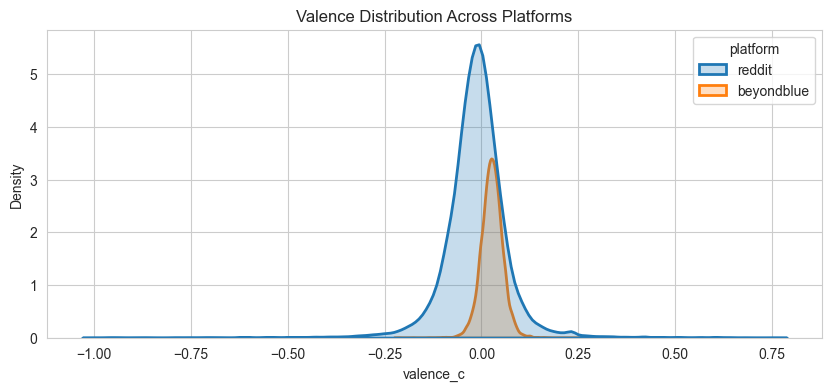

In [135]:
plt.figure(figsize=(10,4))
sns.kdeplot(data=df, x="valence_c", hue="platform", fill=True, linewidth=2)
plt.title("Valence Distribution Across Platforms")
plt.show()


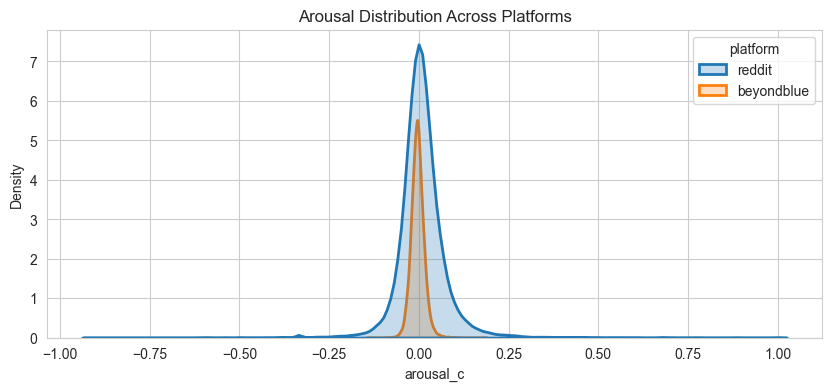

In [136]:
plt.figure(figsize=(10,4))
sns.kdeplot(data=df, x="arousal_c", hue="platform", fill=True, linewidth=2)
plt.title("Arousal Distribution Across Platforms")
plt.show()


In [137]:
from scipy.stats import ks_2samp

reddit_val = reddit_df["valence_c"].dropna()
bb_val     = bb_df["valence_c"].dropna()

reddit_ar = reddit_df["arousal_c"].dropna()
bb_ar     = bb_df["arousal_c"].dropna()

print("Valence KS Test:", ks_2samp(reddit_val, bb_val))
print("Arousal KS Test:", ks_2samp(reddit_ar, bb_ar))


Valence KS Test: KstestResult(statistic=0.12276125456684628, pvalue=1.0106665854354027e-123, statistic_location=0.06640797280235423, statistic_sign=1)
Arousal KS Test: KstestResult(statistic=0.15108749767787477, pvalue=1.6720753098709548e-187, statistic_location=-0.05137324216631166, statistic_sign=-1)


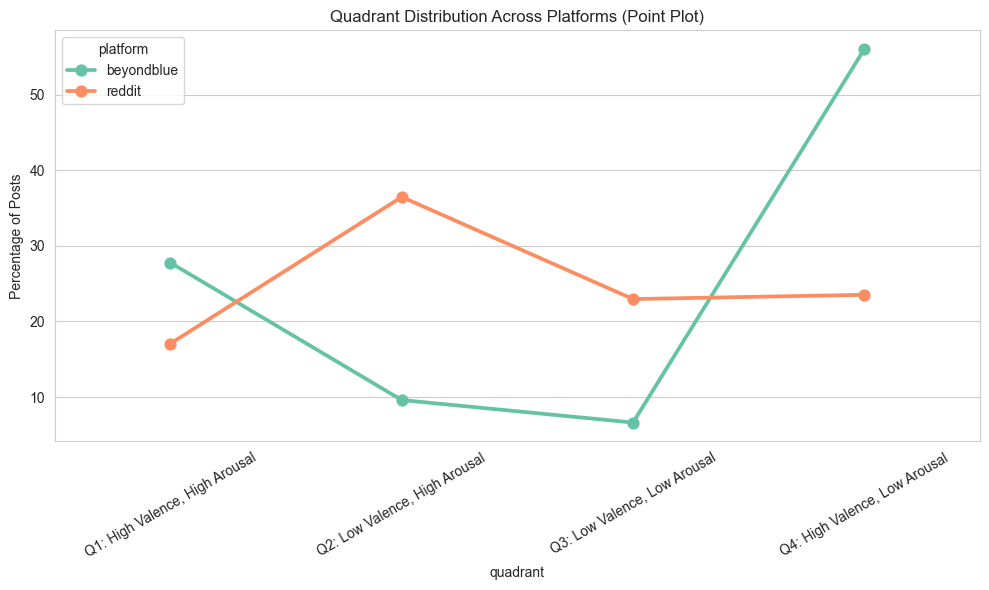

In [138]:
plt.figure(figsize=(10,6))

sns.pointplot(
    data=quad_counts,
    x="quadrant",
    y="percentage",
    hue="platform",
    palette="Set2",
    markers="o",
    linestyles="-"
)

plt.xticks(rotation=30)
plt.ylabel("Percentage of Posts")
plt.title("Quadrant Distribution Across Platforms (Point Plot)")
plt.tight_layout()
plt.show()


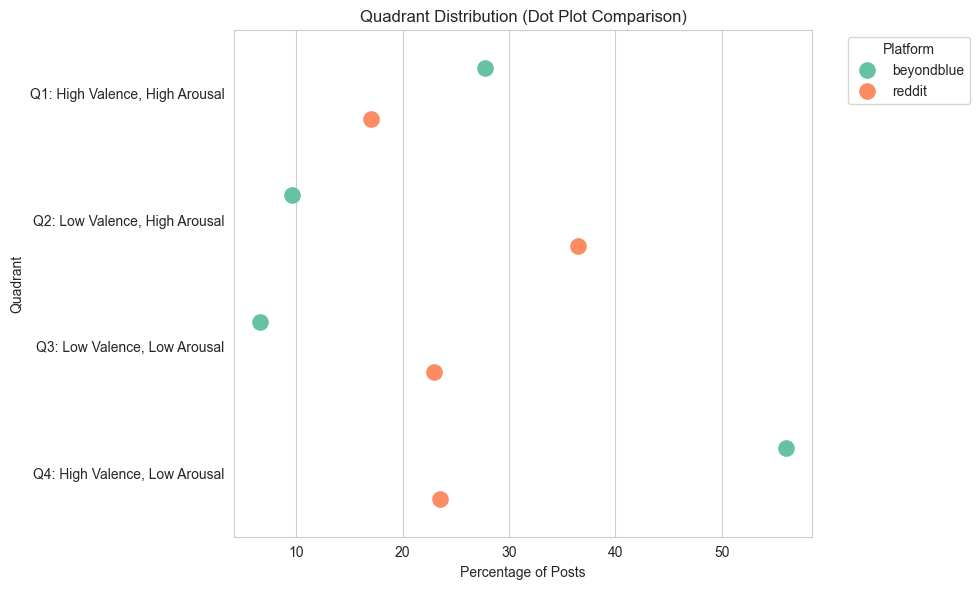

In [139]:
plt.figure(figsize=(10,6))

sns.stripplot(
    data=quad_counts,
    x="percentage",
    y="quadrant",
    hue="platform",
    dodge=True,
    size=12,
    palette="Set2"
)

plt.xlabel("Percentage of Posts")
plt.ylabel("Quadrant")
plt.title("Quadrant Distribution (Dot Plot Comparison)")
plt.legend(title="Platform", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

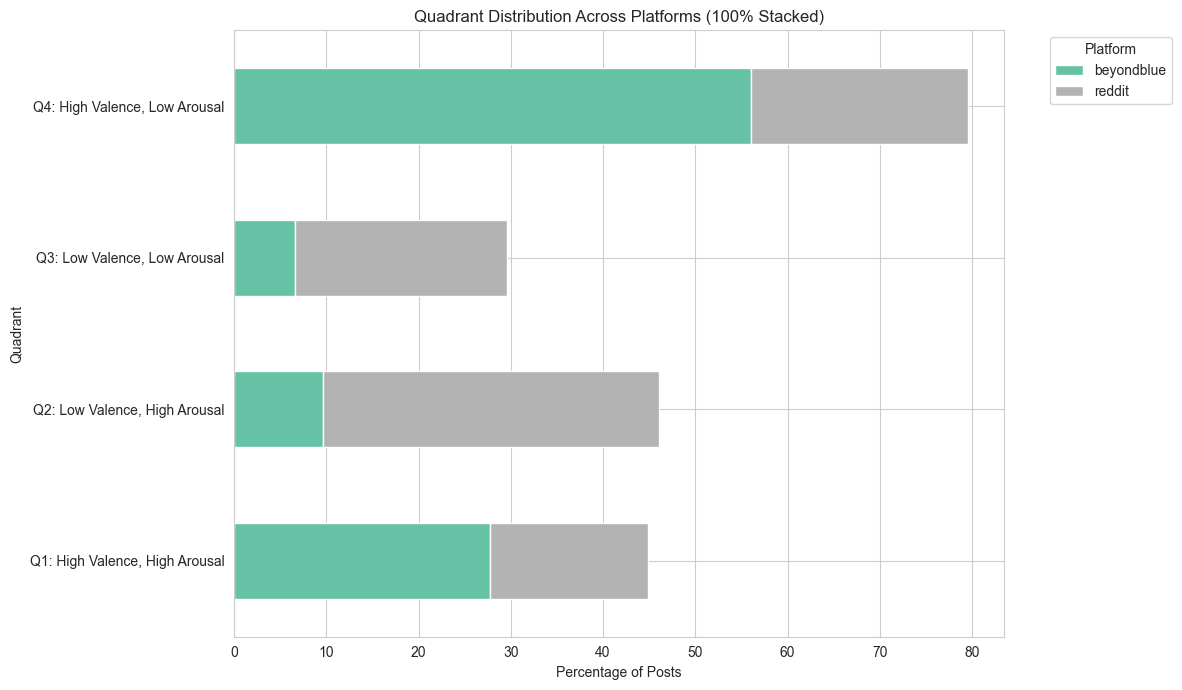

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Pivot for stacked chart
quad_pivot = quad_counts.pivot(index="quadrant", columns="platform", values="percentage")

# Sort quadrants for consistent order
quad_pivot = quad_pivot.loc[
    ["Q1: High Valence, High Arousal",
     "Q2: Low Valence, High Arousal",
     "Q3: Low Valence, Low Arousal",
     "Q4: High Valence, Low Arousal"]
]

plt.figure(figsize=(10,6))
quad_pivot.plot(
    kind="barh",
    stacked=True,
    colormap="Set2",
    figsize=(12,7)
)

plt.xlabel("Percentage of Posts")
plt.ylabel("Quadrant")
plt.title("Quadrant Distribution Across Platforms (100% Stacked)")
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
